In [1]:
import covasim as cv
import pandas as pd
import numpy as np
import ast
import random
import pylab as plt
import random
import datetime
import scipy.stats
plt.style.use('classic')

Covasim 3.0.7 (2021-06-29) — © 2021 by IDM


In [2]:
sim0 = cv.load('zgz_notrun.sim')

In [3]:
avdea = [] #average number of deaths, 7-day average
#average for 0
avdea.append(float(sim0.data.new_deaths[0]+sim0.data.new_deaths[1]+sim0.data.new_deaths[2]+sim0.data.new_deaths[3])/4)
#average for 1
avdea.append(float(sim0.data.new_deaths[0]+sim0.data.new_deaths[1]+sim0.data.new_deaths[2]+sim0.data.new_deaths[3]+sim0.data.new_deaths[4])/5)
#average for 2
avdea.append(float(sim0.data.new_deaths[0]+sim0.data.new_deaths[1]+sim0.data.new_deaths[2]+sim0.data.new_deaths[3]+sim0.data.new_deaths[4]+sim0.data.new_deaths[5])/6)
ndays = len(sim0.data.new_deaths)
for i in range(3,ndays-3):
    avdea.append(float(sum(sim0.data.new_deaths[i-3:i+4]))/7)
#average for ndays-3
avdea.append(float(sim0.data.new_deaths[ndays-6]+sim0.data.new_deaths[ndays-5]+sim0.data.new_deaths[ndays-4]+sim0.data.new_deaths[ndays-3]+sim0.data.new_deaths[ndays-2]+sim0.data.new_deaths[ndays-1])/6)
#average for ndays-2
avdea.append(float(sim0.data.new_deaths[ndays-5]+sim0.data.new_deaths[ndays-4]+sim0.data.new_deaths[ndays-3]+sim0.data.new_deaths[ndays-2]+sim0.data.new_deaths[ndays-1])/5)
#average for ndays-1
avdea.append(float(sim0.data.new_deaths[ndays-4]+sim0.data.new_deaths[ndays-3]+sim0.data.new_deaths[ndays-2]+sim0.data.new_deaths[ndays-1])/4)

(array([18262., 18293., 18322., 18353., 18383., 18414., 18444., 18475.,
        18506., 18536., 18567.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

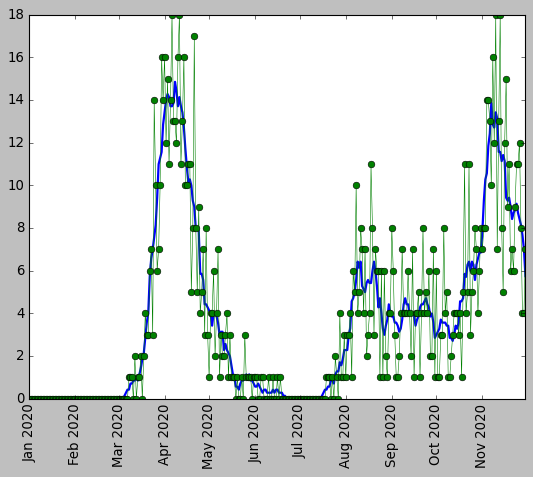

In [4]:
plt.plot(sim0.data.date,avdea,zorder=2,lw=2)
plt.plot(sim0.data.date,sim0.data.new_deaths,'o-',lw=0.5)
plt.xticks(rotation=90)

In [5]:
i0 = list(sim0.people.susceptible).index(False)
print(i0)
nmax = 1+np.amax(sim0.people.uid)
print(nmax)

128037
706178


In [6]:
#INTERVENTIONS (after calibrating parameters)
#Interventions in school
norms = 0.25 #Normalising factor for contacts in school (half size-> 0.25 number of contacts)

schoolclose = cv.clip_edges(days=['2020-03-14','2020-09-07','2020-09-08','2020-09-10','2020-09-17'],
                            changes=[0.0,norms*3./15,norms*9./15,norms*14./15,norms*1.],layers='s')
#Interventions in university
uniclose = cv.clip_edges(days=['2020-03-14','2020-09-14'],
                         changes=[0.0,0.25],layers='u')
#Interventions in community
comclose = cv.clip_edges(days=['2020-03-14','2020-06-01','2020-06-20','2020-08-05','2020-09-04',
                               '2020-10-19','2020-10-26'],
                         changes=[0.0,0.5,0.8,0.5,1.0,0.3,0.1],layers='c')

#Changes in work
workclose = cv.clip_edges(days=['2020-03-14','2020-06-01','2020-07-15','2020-08-01','2020-09-01','2020-09-20'],
                          changes=[0.2,0.7,0.5,0.3,0.3,0.5],layers='w')

#Changes in beta
cb = cv.change_beta(days=['2020-06-01'], changes=[1.0],layers=['w','u','r'])
cbs = cv.change_beta(days=['2020-09-10'],changes=0.5,layers='s')
cbc = cv.change_beta(days=['2020-06-20','2020-10-26'],changes=[1.5,1.0])

#Test probabilities
tp1 = cv.test_prob(symp_prob=0.15, asymp_prob=0.001, start_day='2020-07-01',end_day='2020-09-14',test_delay=1)
tp2 = cv.test_prob(symp_prob=0.09, asymp_prob=0.001, start_day='2020-09-15',test_delay=1)
#Tracing probabilities (of positive tests)
tracp1 = 0.4
tracp2 = 0.45
tracp3 = 0.55

ct1 = cv.contact_tracing(
    trace_probs=dict(h=tracp1*1.0, s=tracp1*0.8, u=tracp1*0.6, w=tracp1*0.8, c=tracp1*0.0, r=0.0), 
                         do_plot=False,quar_period = 14,
                         start_day='2020-07-01',end_day='2020-08-19',trace_time=2)
ct2 = cv.contact_tracing(
    trace_probs=dict(h=tracp2*1.0, s=tracp2*0.8, u=tracp2*0.6, w=tracp2*0.8, c=tracp2*0.05, r=0.0), 
                         do_plot=False,quar_period = 14,
                         start_day='2020-08-20',end_day='2020-09-30',trace_time=2)
ct3 = cv.contact_tracing(
    trace_probs=dict(h=tracp3*1.0, s=tracp3*0.8, u=tracp3*0.6, w=tracp3*0.8, c=tracp3*0.05, r=0.0), 
                         do_plot=False,quar_period = 10,
                         start_day='2020-10-01',trace_time=2)

In [7]:

sim1 = sim0.copy()
sim1['beta']=0.028 #Beta calibrated for first wave
sim1['rel_death_prob'] = 1.0
sim1['start_day'] = '2020-01-01' #Start day calibrated for first wave
sim1['end_day'] = '2020-12-01'
sim1['pop_infected'] = 0
sim1['interventions'] = [schoolclose,uniclose,comclose,workclose,tp1,tp2,cb,cbs,cbc,ct1,ct2,ct3]
sim1['verbose'] = 0
sim1['rescale'] = False
sim1['rescale_factor'] = 1.0
        
        

In [8]:
sims1 = []
random.seed(45)#We set a random seed
for i in range(100): #100 realizations
    sim2 = sim1.copy()
    sim2.people.make_naive([i0])#Make everyone susceptible
    i1 = random.randrange(nmax)#Random seed
    sim2.people.infect([i1])
    k = random.randrange(100000)
    sim2['rand_seed'] = k #Different random seed for each realization
    sim2.initialize()
    sims1.append(sim2)

In [9]:
#Run the 100 realizations
msim = cv.MultiSim(sims1,keep_people=True)
msim.run()

MultiSim(n_sims: 100; base: Sim(<no label>; 2020-01-01 to 2020-12-01; pop: 706178 hybrid; epi: not run))

In [10]:
#Separate the realizations
sims = msim.split(inds = [[i] for i in range(100)])

In [11]:
#Keep realizations surviving both waves
torem = []
for sim in sims:
    sim.mean()
    if sim.results['cum_deaths'][-1] < 10:
        torem.append(sim)
    elif sim.results['cum_deaths'][-1]-sim.results['cum_deaths'][-10] < 10:
        torem.append(sim)
for sim in torem:
    sims.remove(sim)

In [12]:
joined = cv.MultiSim.merge(sims)
joined.median()

In [13]:
print(len(joined))


33


(array([18262., 18293., 18322., 18353., 18383., 18414., 18444., 18475.,
        18506., 18536., 18567., 18597.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

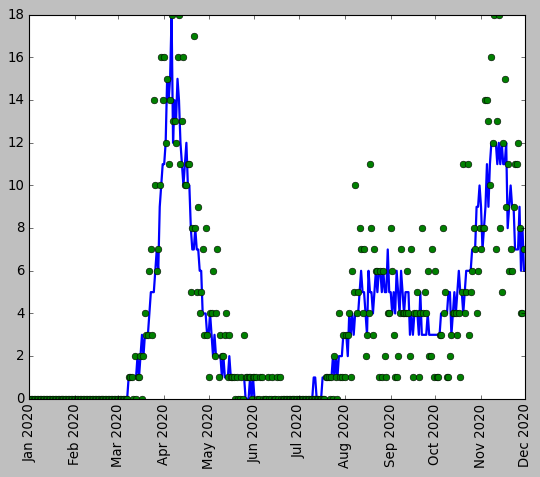

In [14]:
#Compare our results (median) with the real data
plt.plot(joined.results.date,joined.results.new_deaths,zorder=2,lw=2)
plt.plot(sim0.data.new_deaths,'o',lw=0.5)
plt.xticks(rotation=90)

In [15]:
#7-day average of the number of deaths in the model (median of realizations)
moddea = []
#average for 0
moddea.append(float(joined.results.new_deaths[0]+joined.results.new_deaths[1]+joined.results.new_deaths[2]+joined.results.new_deaths[3])/4)
#average for 1
moddea.append(float(joined.results.new_deaths[0]+joined.results.new_deaths[1]+joined.results.new_deaths[2]+joined.results.new_deaths[3]+joined.results.new_deaths[4])/5)
#average for 2
moddea.append(float(joined.results.new_deaths[0]+joined.results.new_deaths[1]+joined.results.new_deaths[2]+joined.results.new_deaths[3]+joined.results.new_deaths[4]+joined.results.new_deaths[5])/6)
ndays = len(joined.results.new_deaths)
for i in range(3,ndays-3):
    moddea.append(float(sum(joined.results.new_deaths[i-3:i+4]))/7)
#average for ndays-3
moddea.append(float(joined.results.new_deaths[ndays-6]+joined.results.new_deaths[ndays-5]+joined.results.new_deaths[ndays-4]+joined.results.new_deaths[ndays-3]+joined.results.new_deaths[ndays-2]+joined.results.new_deaths[ndays-1])/6)
#average for ndays-2
moddea.append(float(joined.results.new_deaths[ndays-5]+joined.results.new_deaths[ndays-4]+joined.results.new_deaths[ndays-3]+joined.results.new_deaths[ndays-2]+joined.results.new_deaths[ndays-1])/5)
#average for ndays-1
moddea.append(float(joined.results.new_deaths[ndays-4]+joined.results.new_deaths[ndays-3]+joined.results.new_deaths[ndays-2]+joined.results.new_deaths[ndays-1])/4)

In [16]:
#7-day average of the number of deaths in each realization
realizdea = []
for sim in joined.sims:
    simdea = []
    #average for 0
    simdea.append(float(sim.results.new_deaths[0]+sim.results.new_deaths[1]+sim.results.new_deaths[2]+sim.results.new_deaths[3])/4)
    #average for 1
    simdea.append(float(sim.results.new_deaths[0]+sim.results.new_deaths[1]+sim.results.new_deaths[2]+sim.results.new_deaths[3]+sim.results.new_deaths[4])/5)
    #average for 2
    simdea.append(float(sim.results.new_deaths[0]+sim.results.new_deaths[1]+sim.results.new_deaths[2]+sim.results.new_deaths[3]+sim.results.new_deaths[4]+sim.results.new_deaths[5])/6)
    ndays = len(sim.results.new_deaths)
    for i in range(3,ndays-3):
        simdea.append(float(sum(sim.results.new_deaths[i-3:i+4]))/7)
    #average for ndays-3
    simdea.append(float(sim.results.new_deaths[ndays-6]+sim.results.new_deaths[ndays-5]+sim.results.new_deaths[ndays-4]+sim.results.new_deaths[ndays-3]+sim.results.new_deaths[ndays-2]+sim.results.new_deaths[ndays-1])/6)
    #average for ndays-2
    simdea.append(float(sim.results.new_deaths[ndays-5]+sim.results.new_deaths[ndays-4]+sim.results.new_deaths[ndays-3]+sim.results.new_deaths[ndays-2]+sim.results.new_deaths[ndays-1])/5)
    #average for ndays-1
    simdea.append(float(sim.results.new_deaths[ndays-4]+sim.results.new_deaths[ndays-3]+sim.results.new_deaths[ndays-2]+sim.results.new_deaths[ndays-1])/4)
    realizdea.append(simdea)
print(len(realizdea))

33


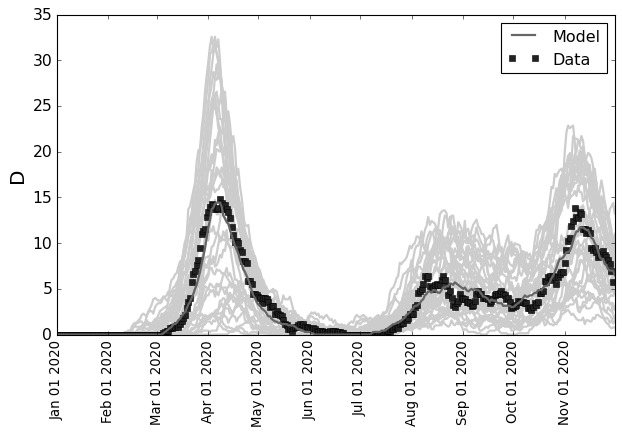

In [17]:
fig = plt.figure(figsize=(9,5))
fig.set_facecolor('w')
ax = plt.gca()
plt.plot(joined.results['date'],moddea,zorder=1,lw=2,c='#666666',label='Model')
for elem in realizdea:
    plt.plot(joined.results['date'],elem,zorder=0,lw=2,c='#cccccc')
plt.plot(sim.data['date'],avdea,'s',zorder=0,label='Data',c='#222222')
ax.set_xlim(pd.to_datetime('2020-01-28'),pd.to_datetime('2020-12-01'))
plt.ylim(0,35)
plt.xticks([pd.to_datetime('2020-'+str(i)+'-01') for i in range(1,12)],size=12,rotation=90)
plt.yticks(size=14)
plt.ylabel('D',size=18)

plt.legend(loc=0)


In [18]:
#Prevalence
print(float(joined.results['cum_infections'][-1])/len(sim0.people.age))

0.22581558757140552


In [19]:
def mean_confidence_interval(data, m, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    se = scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

In [20]:
nd = len(sim.results['new_symptomatic'])
print(nd)

336


In [21]:
dlow = []
dhigh = []
for i in range(nd):
    data = []
    med = moddea[i]
    for elem in realizdea:
        data.append(elem[i])
    sympl,symph = mean_confidence_interval(data,med)
    dlow.append(sympl)
    dhigh.append(symph)

In [22]:
print(dlow)
print(dhigh)
print(moddea)
print(avdea)
print([elem for elem in sim.data['date'].values])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.008817893261732037, -0.008817893261732037, -0.008817893261732037, -0.008817893261732037, -0.008817893261732037, -0.008817893261732037, -0.008817893261732037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.008817893261732039, -0.008817893261732039, -0.014788056563677637, -0.018443947025838438, -0.028402651836469957, -0.03269762333351409, -0.04205867028138264, -0.044089466308660195, -0.0701285892460249, -0.09598956259236192, -0.11035585490462776, -0.1211257286654627, -0.13758103656022846, -0.1475021645037402, -0.17043016878174105, -0.1784125892976394, -0.18487370925835425, -0.2051700365741247, -0.23903038185563283, -0.24889079738415656, -0.27129356028777984, -0.2943776770335534, -0.3299942663535333, -0.33690238035600634, -0.3434382648557534, -0.3509754143322121, -0.382531704492732, -0.2615540726753213, -0.12353477091650816, 0.01859272940181944, 0.12445835561712093, 0.208898487330

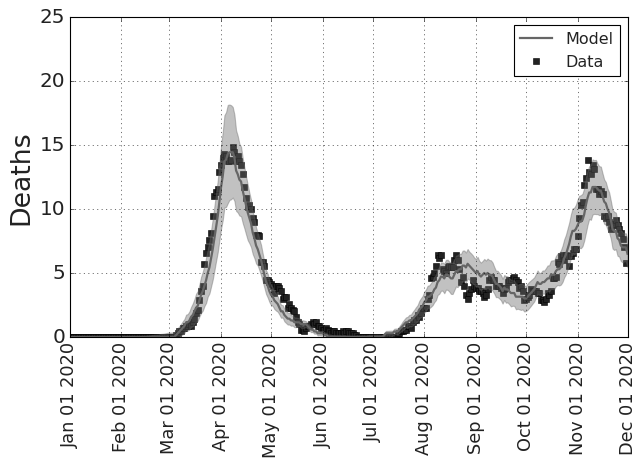

In [23]:
fig = plt.figure(figsize=(9,5))
fig.set_facecolor('w')
ax = plt.gca()
plt.plot(joined.results['date'],moddea,zorder=1,lw=2,c='#666666',label='Model')
ax.fill_between(joined.results['date'],dlow,dhigh,color='#666666',alpha=0.4)
plt.plot(sim.data['date'],avdea,'s',zorder=0,label='Data',c='#222222')
ax.set_xlim(pd.to_datetime('2020-01-28'),pd.to_datetime('2020-12-01'))

plt.xticks([pd.to_datetime('2020-'+str(i)+'-01') for i in range(1,13)],size=16,rotation=90,color='#222222')
plt.yticks(size=18,color='#222222')
plt.ylabel('Deaths',size=24,color='#222222')
l = plt.legend(loc=0,numpoints=1)
for elem in l.get_texts():
    elem.set_color('#222222')
plt.ylim(0,25)
plt.grid()
# fig.savefig('../figs/zaragoza_2w.png',bbox_inches='tight')
# fig.savefig('../figs/zaragoza_2w.pdf',fmt='pdf',bbox_inches='tight')


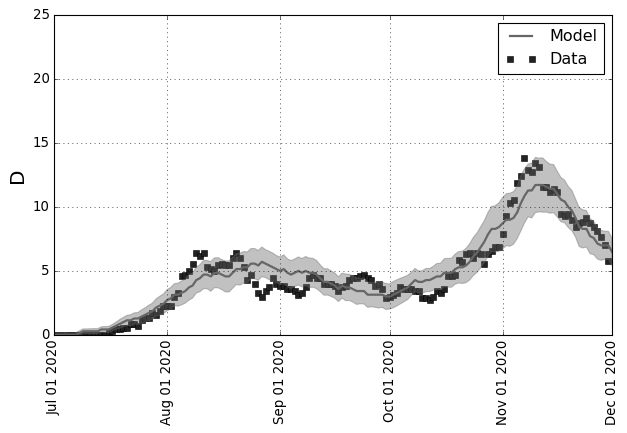

In [24]:
fig = plt.figure(figsize=(9,5))
fig.set_facecolor('w')
ax = plt.gca()
plt.plot(joined.results['date'],moddea,zorder=1,lw=2,c='#666666',label='Model')
ax.fill_between(joined.results['date'],dlow,dhigh,color='#666666',alpha=0.4)
plt.plot(sim.data['date'],avdea,'s',zorder=0,label='Data',c='#222222')
ax.set_xlim(pd.to_datetime('2020-07-01'),pd.to_datetime('2020-12-01'))

plt.xticks([pd.to_datetime('2020-'+str(i)+'-01') for i in range(7,13)],size=12,rotation=90)
plt.yticks(size=12)
plt.ylabel('D',size=18)
plt.legend(loc=0)
plt.ylim(0,25)
plt.grid()


In [25]:
slow = []
shigh = []
for i in range(nd):
    data = []
    med = joined.results['new_symptomatic'][i]
    for elem in joined.sims:
        data.append(elem.results['new_symptomatic'][i])
    sympl,symph = mean_confidence_interval(data,med)
    slow.append(sympl)
    shigh.append(symph)

In [26]:
#####See prevalence per age group
ages = []
agesinf = []
for s in joined.sims:
    for susc, age in zip(s.people.susceptible, s.people.age):
        ages.append(age)
        if susc == False:
            agesinf.append(age)

In [27]:
bintot = [0 for i in range(40)]
bininf = [0 for i in range(40)]

In [28]:
for elem in ages:
    bintot[int(elem/5)] += 1
for elem in agesinf:
    bininf[int(elem/5)] += 1
prev = []
for val,norm in zip(bininf,bintot):
    if norm != 0:
        prev.append(float(val)/norm)
    else:
        prev.append(0.0)

(0.0, 105.0)

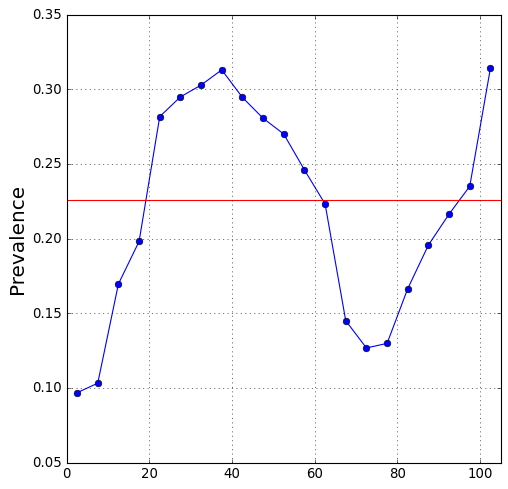

In [29]:
fig = plt.figure(figsize=(7,7))
fig.set_facecolor('w')
plt.plot([5*i+2.5 for i in range(21)],prev[:21],'o-') #Prevalence per 5y age groups
plt.axhline(y=float(joined.results['cum_infections'][-1])/len(sim0.people.age),c='r')#Average prevalence
plt.ylabel('Prevalence',size=18)
plt.grid()
plt.xlim(0,105)

In [30]:
L = len(joined.sims)
tts = [joined.sims[i].make_transtree() for i in range(L) ]

In [31]:
print(tts[0])

————————————————————————————————————————————————————————————
Methods:
  animate()           day()               plot()              
  apply()             finalize()          plot_histograms()   
  count_targets()     initialize()        r0()                
  count_transmiss...  make_detailed()     to_json()           
————————————————————————————————————————————————————————————
     detailed:         source  target  date layer  trg_age  src_age
               trg_date_expo [...]
           df:           Day layer  s_asymp  s_presymp  s_sev  s_crit
               s_diag  s_q [...]
    finalized: False
infection_log: [{'source': None, 'target': 128037, 'date': 0, 'layer':
               'seed_infec [...]
  initialized: False
        label: 'TransTree'
       n_days: 335
    n_targets: array([1., 2., 0., ..., 0., 1., 0.])
     pop_size: 706178
  sim_results: {'t': array([  0,   1,   2,   3,   4,   5,   6,   7,
               8,   9,  10, [...]
    sim_start: datetime.date(2020, 1, 1)
 s

In [32]:
dfs = [pd.DataFrame(tts[i].infection_log) for i in range(L)]

In [33]:
layers = ['h','s','u','r','w','c']
med = []
for l in layers:
    thismed = []
    data = [[0 for i in range(tts[0].n_days+1)] for i in range(L)]
    for i in range(L):
        samp = dfs[i]
        samp = samp[samp['layer'] == l]
        for elem in samp['date']:
            data[i][elem] += 1
    for i in range(tts[0].n_days+1):
        arr = [data[j][i] for j in range(L)]
        thismed.append(np.median(arr))
    med.append(thismed)
    
    

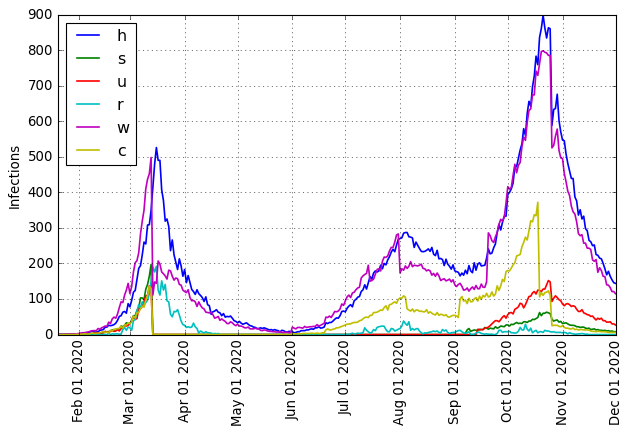

In [34]:
fig = plt.figure(figsize=(9,5))
fig.set_facecolor('w')
for l,m in zip(layers,med):
    plt.plot(joined.sims[0].results['date'],m,label=l,lw=1.5)
plt.legend(loc=0)
# plt.ylim(0,400)
plt.xticks([pd.to_datetime('2020-'+str(i)+'-01') for i in range(1,13)],size=12,rotation=90)
plt.xlim(pd.to_datetime('2020-01-20'),pd.to_datetime('2020-12-01'))
plt.ylabel('Infections')
plt.grid()

In [35]:
print(joined.results.cum_deaths[-1])

1344.0


In [36]:
#we need the cum_deaths confidence interval as well

In [37]:
N = len(sim0.people)
data = []
med = joined.results['cum_infections'][-1]
for elem in joined.sims:
    data.append(elem.results['cum_infections'][-1])
plow,phigh = mean_confidence_interval(data,med)
print(plow/N,med/N,phigh/N)

0.21023776848641257 0.22581558757140552 0.24139340665639844
